# **Homework 1 Report - Artificial Neural Networks and Deep Learning**
## Team: AN30L
* Alberto Rota: *Person Code: 10615751 - Student Number: 964662 - [alberto2.rota@mail.polimi.it](mailto:alberto2.rota@mail.polimi.it)*  
* Gabriele Santicchi: *Person Code: 10579046 - Student Number: 969088 - [gabriele.santicchi@mail.polimi.it](mailto:gabriele.santicchi@mail.polimi.it)*  
* Giuseppe Venezia: *Person Code: 10622477 - Student Number: 968395 - [giuseppe.venezia@mail.polimi.it](mailto:giuseppe.venezia@mail.polimi.it)*  
***

## Setup
Importing dependencies and setting the seed for consistent RNG

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)
seed = 69
print("Seed:",seed)
tf.random.set_seed(seed)

2.6.0
Seed: 69


Here, the full dataset is splitted into training and validation subdirectories with the desidered ratio. The proportion between class samples is equal in the training and validation subdirectories

In [ ]:
import os
import shutil

project_dir = '' # Your project folder here. It should contain the 'training' directory and and empty 'validation' directory
training_dir = os.path.join(project_dir,'training')
validation_dir = os.path.join(project_dir,'validation')

validation_split = 0.20; # 20% of data dedicated to validation
folders = os.listdir(training_dir)
for f in folders:
    files = os.listdir(os.path.join(training_dir,str(f)))
    numf =len(files)
    for i in range(numf//int(1/validation_split)):
        shutil.move(os.listdir(os.path.join(training_dir,str(f),files[i])),
                    os.listdir(os.path.join(validation_dir,str(f),files[i])))

In [24]:
labels = {
    0:"Apple",1:"Blueberry",2:"Cherry",3:"Corn",4:"Grape",5:"Orange",6:"Peach",
    7:"Pepper",8:"Potato",9:"Raspberry",10:"Soybean",11:"Squash",12:"Strawberry",13:"Tomato"}

## Preprocessing
Definition of the function which adds gaussian noise only to the image background. Background pixels are considered as the ones with value lower than 30% of the average brightness value in the whole image. This function isn't used by the generators since it has been estabilished that it does not contribute to make the model robust; however **its application was aimed only at the training dataset, NOT at validation and testing**

In [25]:
from skimage import color

def add_noise(image):
    row,col,_= image.shape
    mean = np.mean(image)
    sigma = 2*mean 
    mask = color.rgb2gray(image)>0.3*mean
    gauss = np.random.normal(mean,sigma,(row,col))
    gauss = gauss.reshape((row,row))
    gauss[mask] = 0
    noisy = np.empty((row,row,3))
    noisy[:,:,0]  = image[:,:,0] + gauss
    noisy[:,:,1]  = image[:,:,1] + gauss
    noisy[:,:,2]  = image[:,:,2] + gauss
    
    # The input preprocessing required by the transfer learning model is applied after the addition of the noise 
    noisy= tf.keras.applications.xception.preprocess_input(noisy) 
    return noisy

Declaration of the *ImageDataGenerator* instances: augmentation is applied only to training dataset. 

In [36]:
bsize = 32 # Batch size is specified here. Because of memory limitations on the VMs used, it is set to a relatively low value of 32

train_data = ImageDataGenerator(
    rotation_range = 180,
    height_shift_range = 50,
    width_shift_range = 50,
    zoom_range = 0.3,
    shear_range= 50,
    channel_shift_range=0.3,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode ='reflect',
    preprocessing_function = tf.keras.applications.xception.preprocess_input,
)
validation_data = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.xception.preprocess_input)

X_train = train_data.flow_from_directory(
    directory=training_dir,
    target_size=(256,256),
    color_mode ='rgb',
    classes = None,
    class_mode= 'categorical', #classes are taken directly from the title of the subdirs and no y_train has to be specified. 
    batch_size = bsize, 
    shuffle = True, 
)

X_val = validation_data.flow_from_directory(
    directory=validation_dir,
    target_size=(256,256),
    color_mode ='rgb',
    classes = None,
    class_mode= 'categorical', 
    batch_size = bsize, 
    shuffle = True, 
)

Found 13159 images belonging to 14 classes.
Found 4569 images belonging to 14 classes.


Here, examples of how images are loaded and augmented are shown. 

*NOTE: The brightness is not on scale due to the presence of negative values after the application of the preprocessing function (values in the range [-1;0] are all displayed as 0)*

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


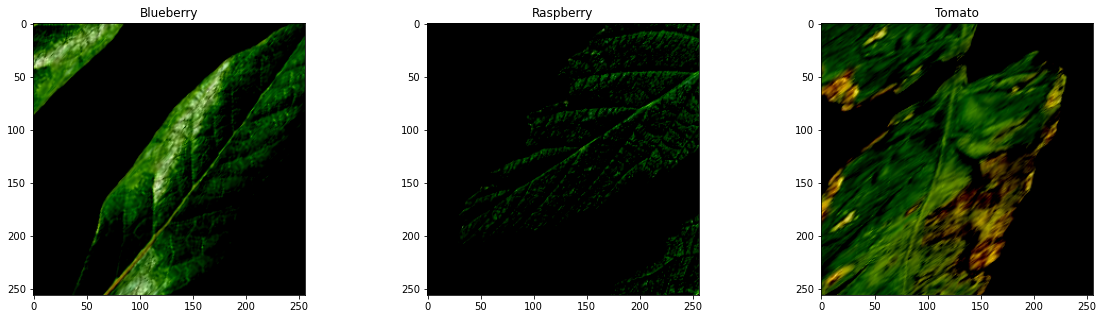

In [ ]:
t = next(X_train)
plt.figure(figsize=(20,5));
plt.subplot(1,3,1);
plt.imshow(t[0][0]);
plt.title(labels[np.argmax(t[1][0])]);
plt.subplot(1,3,2);
plt.imshow(t[0][1]);
plt.title(labels[np.argmax(t[1][1])]);
plt.subplot(1,3,3);
plt.imshow(t[0][2]);
plt.title(labels[np.argmax(t[1][2])]);

## Building the Model

The Xception supernet used as a feature extractor is downloaded and initialized

In [37]:
feature_ext = tfk.applications.Xception(
    include_top=False,  
    weights="imagenet",
)

This function returns the model after appending additional layers to the pretrained supernet

In [38]:
def build_model(input_shape):
    input_layer = tfkl.Input(shape = input_shape, name ='Input')
    x = feature_ext(input_layer)
    
    # First convolutional layer. Brings the shape from 8x8x2048 (Xception output) to an 8x8x18
    x=tfkl.Conv2D(
        filters=18, # Extracts 18 features
        kernel_size=(3,3),
        strides=(1,1), 
        padding='same',
        kernel_initializer=tfk.initializers.GlorotUniform(seed),
        kernel_regularizer=tfk.regularizers.L2(1e-3)
    )(x)
    x = tfkl.BatchNormalization()(x)
    x=tfkl.Activation(
        tfk.activations.relu
    )(x)
    
    # Second convolutional layer. Brings the shape from 8x8x18 to an 8x8x14. These 14 feature maps will be provided to GAP
    x=tfkl.Conv2D(
        filters=14, # Extracts 14 features
        kernel_size=(3,3),
        strides=(1,1), 
        padding='same',
        kernel_initializer=tfk.initializers.GlorotUniform(seed),
        kernel_regularizer=tfk.regularizers.L2(1e-3) 
    )(x)
    x = tfkl.BatchNormalization()(x) 
    x=tfkl.Activation(
        tfk.activations.relu
    )(x)
    
    # The GAP-Softmax combination highlights the feature, among the 14 8x8 maps, which best classified the input image
    x = tfkl.GlobalAveragePooling2D()(x)
    x= tfkl.Softmax()(x)
    output_layer = x
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='xception_18_14_gap_model')

    return model

model = build_model((256,256,3))   
model.summary()
from keras.utils.layer_utils import count_params
trainable_before_freezing = count_params(model.trainable_weights)

Model: "xception_18_14_gap_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 256, 256, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, None, None, 2048)  20861480  
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 8, 8, 18)          331794    
_________________________________________________________________
batch_normalization_10 (Batc (None, 8, 8, 18)          72        
_________________________________________________________________
activation_2 (Activation)    (None, 8, 8, 18)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 8, 8, 14)          2282      
_________________________________________________________________
batch_normalization_11 (Batc (None, 8, 8, 

Since transfer learning is performed, the layers belonging to the *Xception* functional object are not trained. This condition is set here: the number of trainable parameters drastically drops

In [40]:
# Freeze first N layers, e.g., until 14th
for i, layer in enumerate(model.get_layer('xception').layers[:-10]):
    layer.trainable=False
for i, layer in enumerate(model.get_layer('xception').layers[-10:]):
    layer.trainable=True
    print(f"TRAINABLE: {i}-{layer.name}")

model.summary()
trainable_after_freezing = count_params(model.trainable_weights)
print(f"Trainable parameters WITHOUT transfer learning: {trainable_before_freezing}")
print(f"Trainable parameters WITH transfer learning: {trainable_after_freezing}")
print(f"REDUCTION: {(trainable_after_freezing-trainable_before_freezing)/trainable_before_freezing*100}%")

TRAINABLE: 0-conv2d_9
TRAINABLE: 1-block13_pool
TRAINABLE: 2-batch_normalization_9
TRAINABLE: 3-add_23
TRAINABLE: 4-block14_sepconv1
TRAINABLE: 5-block14_sepconv1_bn
TRAINABLE: 6-block14_sepconv1_act
TRAINABLE: 7-block14_sepconv2
TRAINABLE: 8-block14_sepconv2_bn
TRAINABLE: 9-block14_sepconv2_act
Model: "xception_18_14_gap_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 256, 256, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, None, None, 2048)  20861480  
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 8, 8, 18)          331794    
_________________________________________________________________
batch_normalization_10 (Batc (None, 8, 8, 18)          72        
_________________________________________________________________
activatio

## Training
Setting up the loss function, the optimizer and the metrics

In [ ]:
learning_rate = 1e-3
opt = tfk.optimizers.Adam(learning_rate)
loss = tfk.losses.CategoricalCrossentropy()
mtr = [tfk.metrics.Recall(), 'accuracy']
model.compile(loss=loss, optimizer=opt, metrics=mtr)

model_name = 'xception_18_14_gap'
modeldir = os.path.join(project_dir,model_name) # Where the model will be saved

#### Callbacks declaration

Early Stopping

In [ ]:
callbacks = []
earlystop = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)
callbacks.append(earlystop)

Readuce Learning rate on plateau

In [ ]:
reducelr = tfk.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.1,
    patience=8,
    verbose=1,
    mode="max"
)
callbacks.append(reducelr)

Checkpoints and TensorBoard

In [ ]:
ckpt_dir = os.path.join(modeldir, 'checkpoints')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)
ckpt_callback = tfk.callbacks.ModelCheckpoint(
    filepath = ckpt_dir ,
    save_weights_only = False, 
    save_best_only = True
)
callbacks.append(ckpt_callback)

TB = tfk.callbacks.TensorBoard(log_dir = os.path.join(modeldir,'tblogs'))
callbacks.append(TB)


Class weights computed by sklearn *compute_class_weights* are allocated in a dictionary, which will be then passed to the *fit* method. As expected, classes with an higher number of samples have a lower weights 

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight(class_weight='balanced', classes=np.unique(X_train.classes), y=X_train.classes)
keys = np.arange(0,14,1)
weight_dictionary_fold = dict(zip(keys, weights))
print("CLASS WEIGHTS:\n",weight_dictionary_fold)

CLASS WEIGTHS:
 {0: 1.4848792597607763, 1: 3.133095238095238, 2: 2.5131779984721163, 3: 1.2175240562546261, 4: 1.0063475068828387, 5: 0.8392219387755102, 6: 1.2019546949214468, 7: 1.5358309990662933, 8: 1.6403639990027425, 9: 4.433625336927224, 10: 0.7269362501381063, 11: 2.0433229813664595, 12: 1.7438377948582031, 13: 0.20635094872196957}


### Model Training

In [ ]:
training_history = model.fit(
    x = X_train,
    epochs = 75,
    steps_per_epoch = len(X_train.filenames)//bsize,
    validation_data = X_val,
    callbacks = callbacks,
    class_weight = weight_dictionary_fold
).history
model.save(os.path.join(modeldir,f"{model_name}_finalmodel.h5"))

Metrics are saved into a *.csv* file for further analysis and graphing

In [ ]:
with open("history.csv",'w') as f:
  f.write(f"loss,recall,accuracy,vloss,vrecall,vaccuracy\n")
  for i in range(len(training_history['loss'])):
    f.write(f"{training_history['loss'][i]},{training_history['recall_3'][i]},{training_history['accuracy'][i]},{training_history['val_loss'][i]},{training_history['val_recall_3'][i]},{training_history['val_accuracy'][i]},\n")

### Refining
Training is repeated, for a lower number of epochs, with a decreased learning rate. This step should "refine" the network and eventually increase its overall accuracy 

In [ ]:
learning_rate = 1e-6
opt = tfk.optimizers.Adam(learning_rate)
loss = tfk.losses.CategoricalCrossentropy()
mtr = [tfk.metrics.Recall(), 'accuracy']
model.compile(loss=loss, optimizer=opt, metrics=mtr)

inception_history = model.fit(
    x = X_train,
    epochs = 20,
    steps_per_epoch = len(X_train.filenames)//bsize,
    validation_data = X_val,
    callbacks = callbacks,
    class_weight = weight_dictionary_fold
).history
model.save(os.path.join(modeldir,f"{model_name}_finalmodel_refined.h5"))

As the **very last step**, after the model has been validated, a further fitting phase is applied on 100% of the data available; the model is trained for 20 additional epochs on the complete dataset available, so that the 20% of data held for validation isn't "wasted".

One additional *ImageDataGenerator* is initialized, which flows from a directory *training_and_validation" which contains the full (non-splitted) dataset

In [ ]:
training_and_val_dir = os.path.join(project_dir,'training_and_validation')
bsize = 64
train_and_val_data = ImageDataGenerator(
    rotation_range = 180,
    height_shift_range = 50,
    width_shift_range = 50,
    zoom_range = 0.3,
    shear_range= 50,
    channel_shift_range=0.3,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode ='nearest',
    preprocessing_function = tf.keras.applications.xception.preprocess_input ,
)
X_train_and_val = train_and_val_data.flow_from_directory(
    directory=training_and_val_dir,
    target_size=(256,256),
    color_mode ='rgb',
    classes = None,
    class_mode= 'categorical', 
    batch_size = bsize, 
    shuffle = True, 
)

learning_rate = 1e-6
opt = tfk.optimizers.Adam(learning_rate)
loss = tfk.losses.CategoricalCrossentropy()
mtr = [tfk.metrics.Recall(), 'accuracy']
model.compile(loss=loss, optimizer=opt, metrics=mtr)

inception_history = model.fit(
    x = X_train_and_val,
    epochs = 20,
    steps_per_epoch = len(X_train.filenames)//bsize,
    validation_data = X_val,
    callbacks = callbacks,
    class_weight = weight_dictionary_fold
).history
model.save(os.path.join(modeldir,f"{model_name}_finalmodel_refined_100percent.h5"))